In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,precision_recall_curve,classification_report,auc
from sklearn.model_selection import learning_curve,cross_val_score,LearningCurveDisplay
import joblib

In [3]:
# load train and test datasets
x_train = pd.read_parquet('data/x_train.parquet')
y_train = pd.read_parquet('data/y_train.parquet')['y_train']
x_test = pd.read_parquet('data/x_test.parquet')
y_test = pd.read_parquet('data/y_test.parquet')['y_test']

In [4]:
# load the best model 
best_model = joblib.load('models/XGB Classifier_best_model.pkl')

In [5]:
# preform predictions using a custom threshold of 0.3 
y_pred_proba = best_model.predict_proba(x_test)[:,1]
threshold = 0.7
y_pred = (y_pred_proba >= threshold).astype(int)

In [6]:
# cross validation across the 5 folds of training, return the mean and std cv score
cv_score = cross_val_score(best_model,x_train,y_train,cv=5,scoring='f1_macro',n_jobs=-1,verbose=2)
print('F1 score across folds: ',cv_score)
print('Mean score : ', cv_score.mean())
print('Standard deviation : ',cv_score.std())

# Insights: 
# Small standard deviation and similar ranges of values across 5 folds suggests that the model is stable 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


F1 score across folds:  [0.80740782 0.82350655 0.81691958 0.8110862  0.81642496]
Mean score :  0.8150690206756455
Standard deviation :  0.0054956693327632665


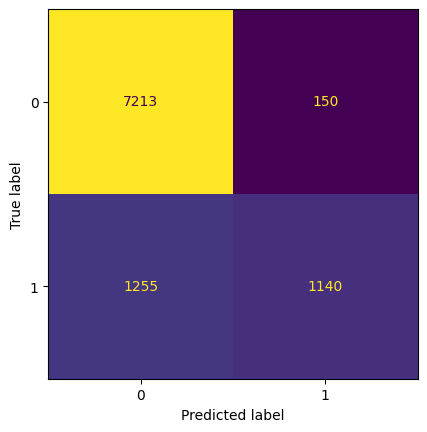

In [7]:
# 1. Model evaluation 
# Confusion matrix - analyse classifications and misclassifications of labels through visuals
# Top left - True Negatives(TN) - correctly predicted negatives
# Top right - False Positive(FP) - actual negatives predicted as positives
# Bottom left - False Negatives(FN) - Actual positves predicted as negatives
# Bottom right - True Positives(TP) - corrrectly predicted positives
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=best_model.classes_)
disp.plot(cmap='viridis',colorbar=False)
plt.show()

In [8]:
from sklearn.metrics import precision_recall_curve,precision_score,recall_score, auc, roc_curve,average_precision_score

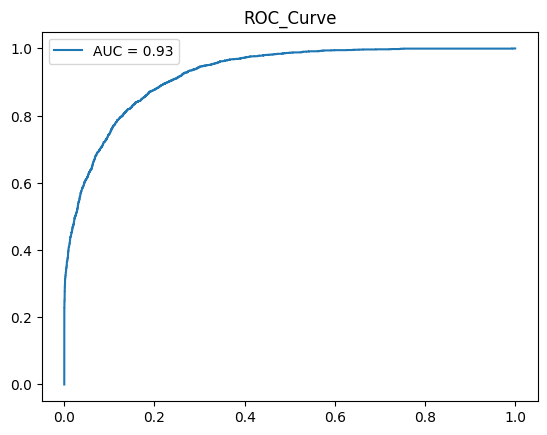

In [9]:
fpr, tpr, _ = roc_curve(
    y_test,y_pred_proba
)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label=f'AUC = {roc_auc:.2f}')
plt.legend()
plt.title('ROC_Curve')
plt.show()

# Determines if the model is actually classifying models based on learned parameters or is just randomly guessing
# 1.0 - perfect classifier
# 0.5 - random guessing

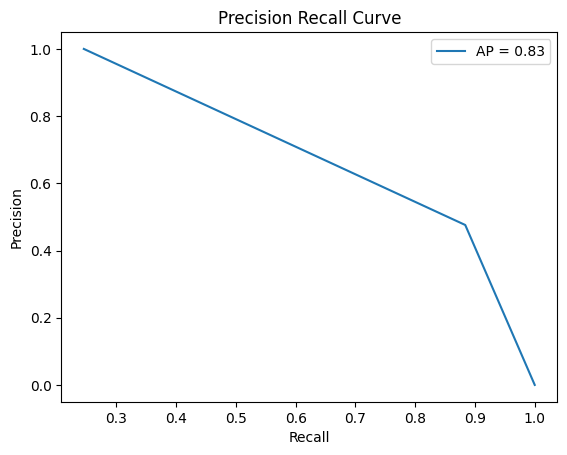

In [10]:
precision, recall, _ = precision_recall_curve(
    y_test,y_pred
)
ap = average_precision_score(y_test,y_pred_proba)
plt.plot(precision,recall,label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

In [11]:
print('Precision score : ',precision_score(y_test,y_pred))

Precision score :  0.8837209302325582


In [12]:
print('Recall score : ',recall_score(y_test,y_pred))

Recall score :  0.4759916492693111


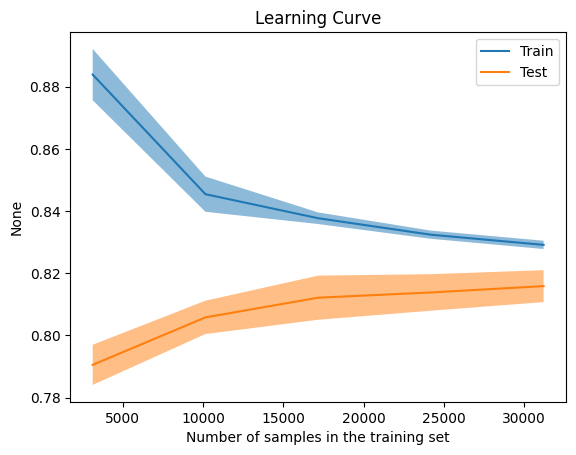

In [13]:
# 2. Learning Curve - A visual plot of how the model learns - bias and variance tradeoff
train_sizes, train_score, test_score = learning_curve(
    best_model,x_train,y_train,cv = 5, scoring='f1_macro'
)
disp = LearningCurveDisplay(train_sizes=train_sizes,
                            train_scores=train_score,
                            test_scores=test_score)
disp.plot()
plt.title('Learning Curve')
plt.show()

#Insight - Learning curve shows model learns and generalises well, no overfitting or underfitting

In [14]:
# 3. Log loss - loss function for some classification models
from sklearn.metrics import log_loss
print('Log Loss : ',log_loss(y_test,y_pred))

Log Loss :  5.189724637395941


In [15]:
onehot_model = joblib.load('models/XGBClassifer_onehot_model.pkl')

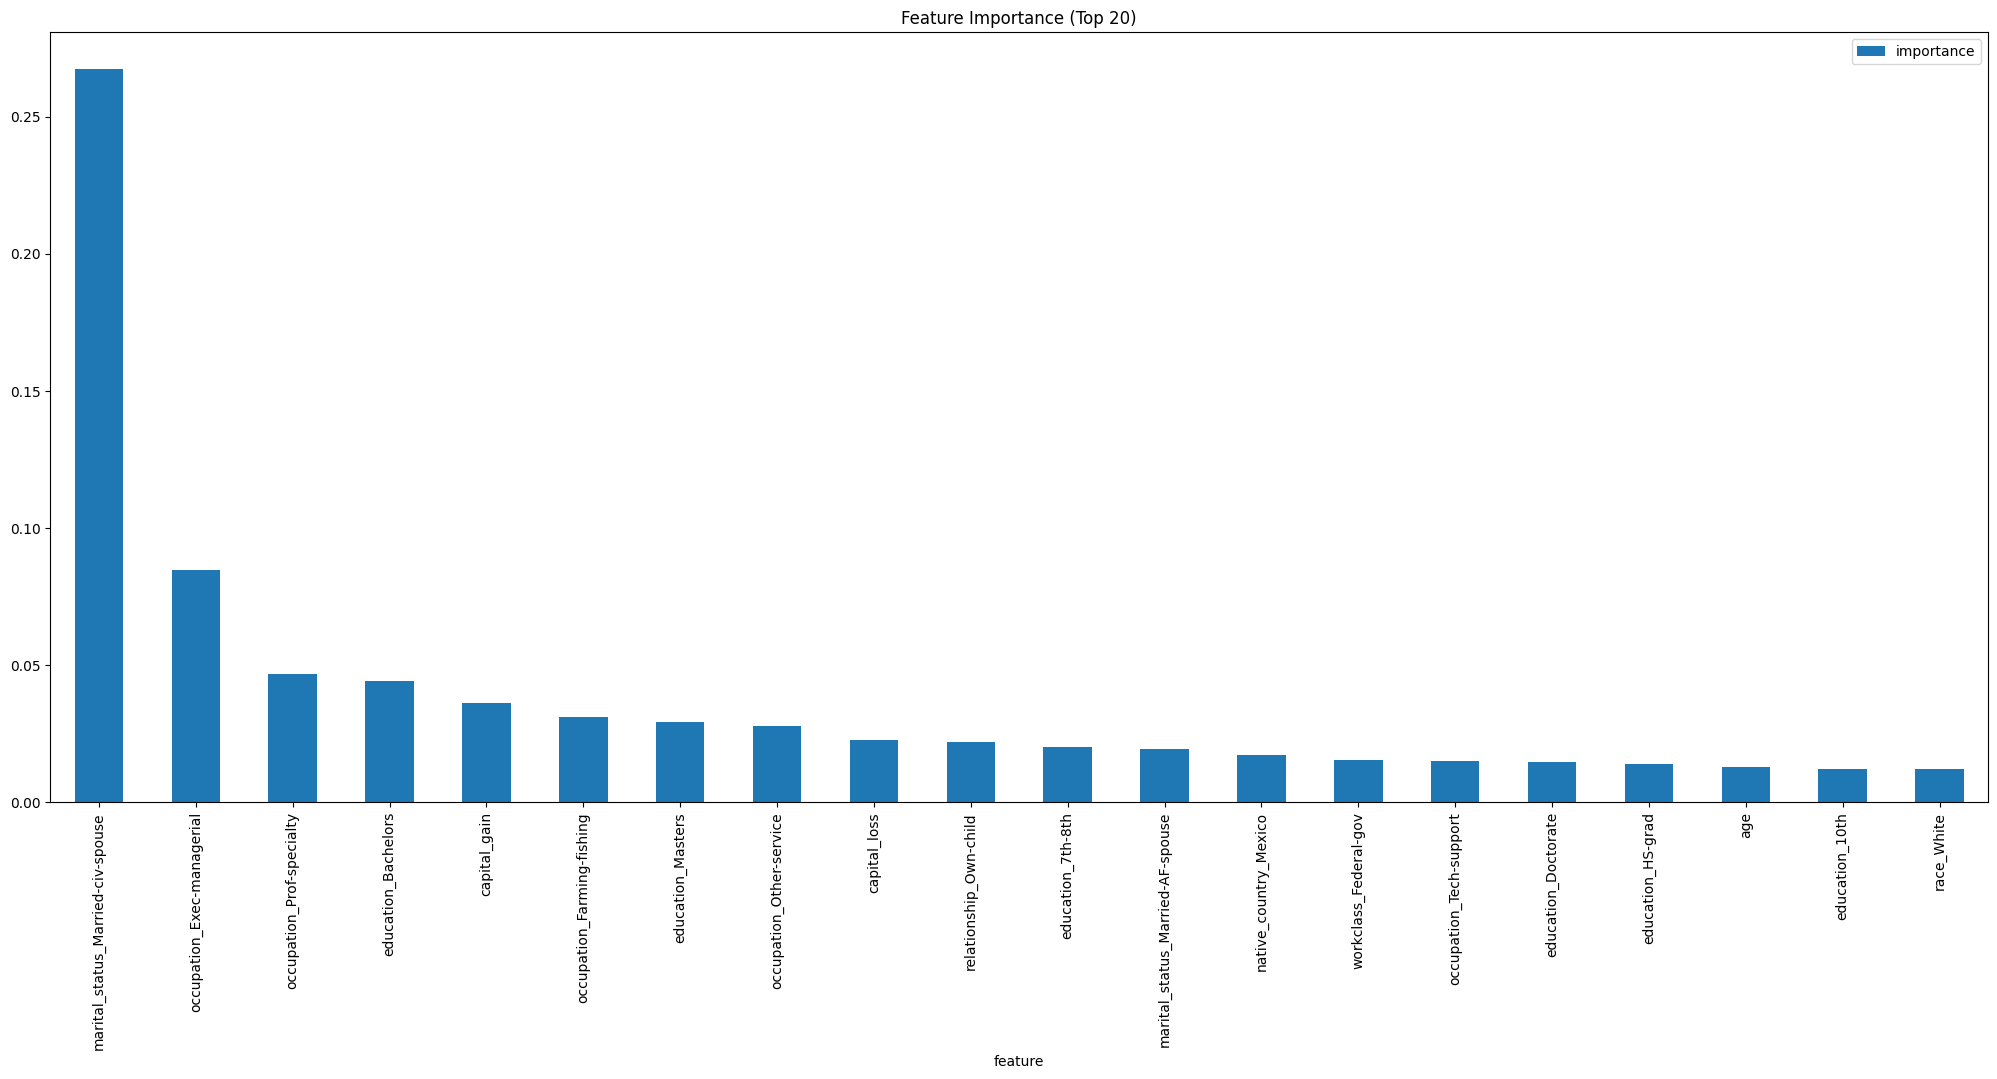

In [19]:
# feature importance for tree based models
feature_names = onehot_model.named_steps['preprocessor'].get_feature_names_out()

# feature importance
importances = onehot_model.named_steps['classifier'].feature_importances_

feature_imp = pd.DataFrame({
    'feature': feature_names,
    'importance' : importances
}).sort_values(by='importance',ascending=False).head(20).plot.bar(x='feature',y='importance',figsize=(25,10))
plt.title('Feature Importance (Top 20)')

plt.savefig('plots/feature_importance.png',bbox_inches='tight',dpi=300)
plt.show()

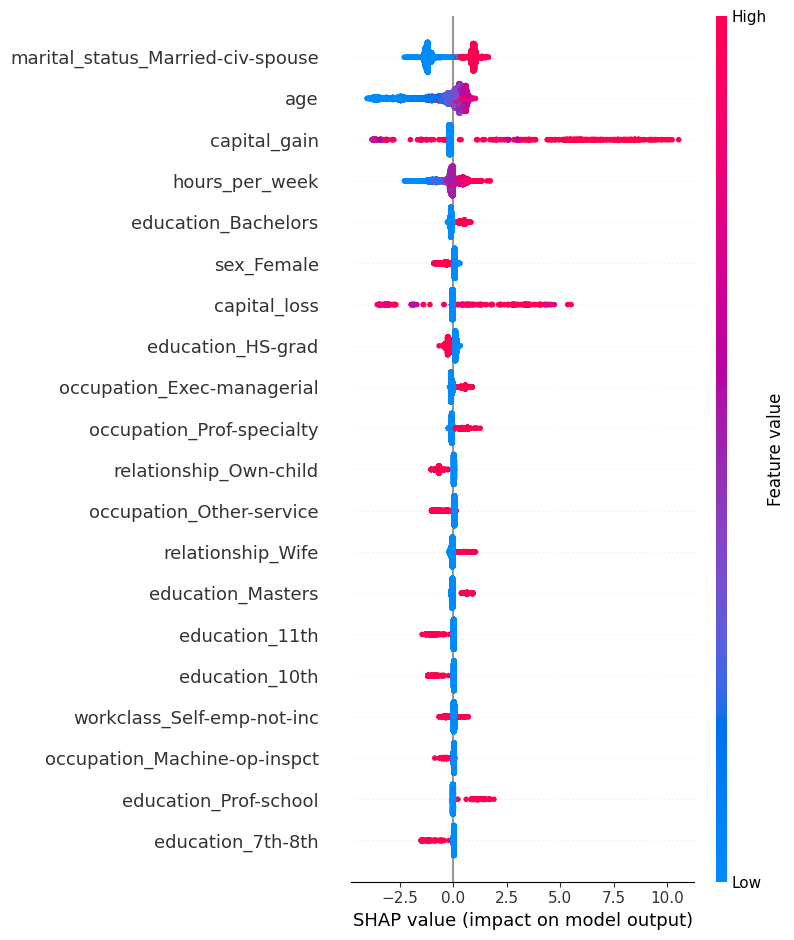

In [22]:
import shap
x_test_transformed = onehot_model.named_steps['preprocessor'].transform(x_test)
explainer = shap.TreeExplainer(onehot_model.named_steps['classifier'])
shap_values = explainer(x_test_transformed)

plt.figure(figsize=(14,8))
shap.summary_plot(shap_values,x_test_transformed,feature_names=feature_names,show=False)

plt.savefig('plots/shap_sumary.png',bbox_inches='tight',dpi=300)
plt.show()